In [1]:
import numpy as np
import pandas as pd
import glob
import os
import random

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, LearningCurveDisplay, ShuffleSplit, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer, OneHotEncoder
import fcalc
from mlxtend.feature_selection import SequentialFeatureSelector

import seaborn as snx
import xgboost as xgb
random.seed(42)

# SC_data

In [2]:
os.chdir("C:/Users/HP pavilion X360/Desktop/OSDA/big_homework")

In [6]:
data = pd.read_csv('data_sc_for_osda.csv')
data.head(3)

,Unnamed: 0,MEG2142,MEG2132,MEG2122,MEG1932,MEG2332,MEG2542,MEG1742,MEG1732,MEG2512,MEG1922,MEG2342,MEG2112,target
0,1,0.093108,-0.223414,-1.059883,-1.720365,0.702428,2.855179,-1.282480,1.611961,-0.205705,0.772891,1.830294,2.291408,0
1,2,-0.502069,-1.102283,1.077575,1.148038,-1.324281,-0.290751,-1.964517,-0.725845,-1.492331,-1.904653,-2.612012,-1.997749,0
2,3,1.747480,0.266660,2.695567,0.781695,1.184406,0.730803,0.437738,-1.454192,0.330962,-0.364799,-0.007068,1.079166,0


In [7]:
y = data['target']
data.drop(['Unnamed: 0', 'target'], axis = 1, inplace = True)
X = data

In [8]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([964, 964], dtype=int64))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3)

In [6]:
stsc = StandardScaler()
stsc.fit(X_train)
train = pd.DataFrame(stsc.transform(X_train))
test = pd.DataFrame(stsc.transform(X_test))

In [10]:
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', subsample=None).fit(train)
new_train = pd.DataFrame(kbins.transform(train), columns = X.columns)
new_test = pd.DataFrame(kbins.transform(test), columns = X.columns)

In [11]:
ohe = OneHotEncoder(drop = 'first').fit(new_train)
ohe_train = ohe.transform(new_train).toarray()
ohe_test = ohe.transform(new_test).toarray()

In [12]:
ohe_test.shape, ohe_train.shape

((579, 36), (1349, 36))

In [13]:
columns = [i + ' ' + 'q' + str(j) for i in X.columns for j in [2,3,4]]
len(columns)
# columns

36

In [19]:
# data = pd.read_csv('data_sc_for_osda.csv')

In [20]:
# data.drop('Unnamed: 0', axis = 1, inplace = True)
# y = data.target
# data.drop('target', axis = 1, inplace = True)
# stsc = StandardScaler()
# stsc.fit(data)
# data = pd.DataFrame(stsc.transform(data))

In [21]:
# label_encoder = LabelEncoder()
# n_bins = 5
# data = pd.DataFrame(data)
# df= pd.DataFrame()
# for i in range(len(data.columns)):
#     df[i] = label_encoder.fit_transform(pd.cut(data[i], n_bins, retbins=True)[0])
# # df = label_encoder.fit_transform(pd.cut(data[0], n_bins, retbins=True)[0])

In [22]:
# one_hot_encoded_data = pd.get_dummies(df, columns = df.columns)
# one_hot_encoded_data
# one_hot_encoded_data['target'] = y
# one_hot_encoded_data.to_csv('one_hot_encoded_sc_data.csv')

In [23]:
# X = pd.read_csv('one_hot_encoded_sc_data.csv')
# y = X['target']
# X.drop('target', axis = 1, inplace = True)
# X_train, X_test, y_train, y_test = train_test_split(np.array(X), y*1, test_size = 0.3)


In [14]:
ohe_train.shape

(1349, 36)

In [15]:
ohe_train.shape, y_train.shape,len(columns)

((1349, 36), (1349,), 36)

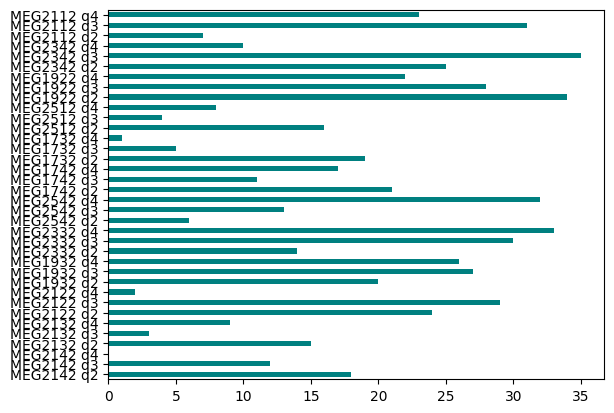

In [17]:
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt

# Вычисляем критерий
# Где X, y - входные и выходные данные соответственно.
ranks = fisher_score.fisher_score(ohe_train, y_train)

# Делаем график наших "фич"
# Где data - ваш датасет
feature_importances = pd.Series(ranks, columns)
feature_importances.plot(kind='barh', color='teal')
plt.show()

In [18]:
len((feature_importances[feature_importances > 15]).sort_values(ascending = False))

20

In [28]:
# from sklearn.metrics import accuracy_score, f1_score

# indx = np.where(bin_cls.predictions != -1)[0]
# print(accuracy_score(y_test.values[indx], bin_cls.predictions[indx]))
# print(f1_score(y_test.values[indx], bin_cls.predictions[indx]))

In [29]:
# ohe_train_sel = ohe_train[:, feature_importances>15].astype(int)
# ohe_test_sel = ohe_test[:, feature_importances>15].astype(int)

## 1. KNN

Best params: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 28, 'weights': 'uniform'}


<Axes: >

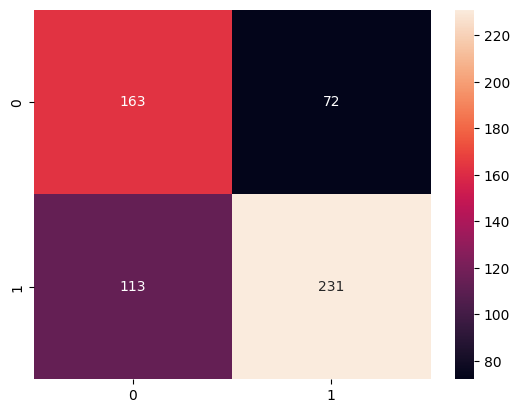

In [21]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1, 30, 1), 'metric': ('euclidean', 'manhattan'),
              'algorithm':['ball_tree', 'kd_tree', 'auto'],
             'weights':('uniform', 'distance')}
grid = GridSearchCV(knn, parameters, cv = 4)

grid.fit(ohe_train, y_train)
print(f'Best params: {grid.best_params_}')
knn_pred = KNeighborsClassifier(metric = grid.best_params_['metric'], n_neighbors = grid.best_params_['n_neighbors'],
                               weights = grid.best_params_['weights'])
knn_pred.fit(ohe_train, y_train)

y_pred = knn_pred.predict(ohe_test)

contingency_matrix = metrics.cluster.contingency_matrix(y_pred,
                                                      y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [22]:
print(f'Accuracy: {metrics.accuracy_score(y_pred = y_pred, y_true = y_test)}')
# print(f'Precision: {metrics.precision_score(y_pred = y_pred, y_true = y_test)}')
# print(f'Recall: {metrics.recall_score(y_pred = y_pred, y_true = y_test)}')
print(f'f1: {metrics.f1_score(y_pred = y_pred, y_true = y_test)}')

Accuracy: 0.6804835924006909
f1: 0.7140649149922721


## 2. Logistic Regression

Best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}


<Axes: >

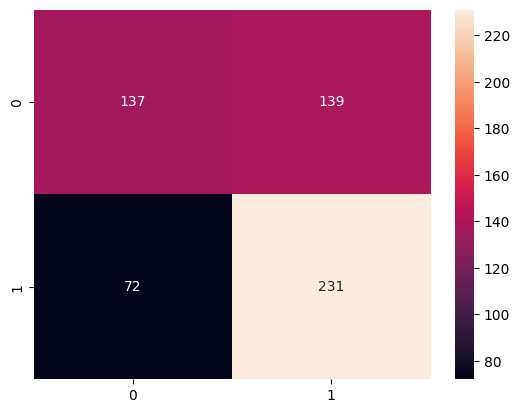

In [24]:
lr = LogisticRegression(max_iter = 100000, random_state = 42)
parameters = {'C':np.arange(0.1, 15, 1), 'penalty': ('l2', 'l1'),
             'class_weight': ['balanced'],
             'solver' : ['saga', 'liblinear']}
grid = GridSearchCV(lr, parameters, cv = 4,  n_jobs = -2)

grid.fit(ohe_train, y_train)
print(f'Best params: {grid.best_params_}')
    
lr_pred = LogisticRegression(C = grid.best_params_['C'], penalty = grid.best_params_['penalty'],
                               class_weight = grid.best_params_['class_weight'],
                            solver = grid.best_params_['solver'])
lr_pred.fit(ohe_train, y_train)

y_pred = lr_pred.predict(ohe_test)

contingency_matrix = metrics.cluster.contingency_matrix(y_test,
                                                      y_pred)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [26]:
print(f'Logistic Regression accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# print(f'Logistic Regression precision: {metrics.precision_score(y_test, y_pred)}')
# print(f'Logistic Regression recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Logistic Regression f1: {f1_score(y_test, y_pred)}')

Logistic Regression accuracy: 0.6355785837651122
Logistic Regression f1: 0.6864784546805349


In [34]:
# bfs = SequentialFeatureSelector(lr_pred, k_features='best', forward = False, n_jobs=-1)
# bfs.fit(ohe_train.toarray(), y_train)
# features = list(bfs.k_feature_names_)
# features = list(map(int, features))
# lr_pred.fit(ohe_train.toarray()[:, features], y_train)
# y_pred = lr_pred.predict(ohe_test.toarray()[:, features])

In [35]:
# print(f'Logistic Regression accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# print(f'Logistic Regression precision: {metrics.precision_score(y_test, y_pred)}')
# print(f'Logistic Regression recall: {metrics.recall_score(y_test, y_pred)}')
# print(f'Logistic Regression f1: {f1_score(y_test, y_pred)}')

## 3.a XGBoost

In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=500,class_sep=0.7)

data_dmatrix = xgb.DMatrix(data=ohe_train,label=y_train)
params = {'objective':'binary:logistic','eval_metric':'logloss',
          'eta':0.01,
          'subsample':0.1}
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=94)

In [33]:
from sklearn.base import clone
clf = xgb.XGBClassifier(tree_method="hist", nfold=4, metrics = 'logloss', seed=42)

resutls = {}

for train, test in cv.split(ohe_train, y_train):
    X_train = ohe_train[train]
    X_test = ohe_train[test]
    y_train_cv = y_train[train]
    y_test_cv = y_train[test]
    est, train_score, test_score = fit_and_score(
        clone(clf), X_train, X_test, y_train_cv, y_test_cv
    )
    resutls[est] = (train_score, test_score)

[0]	validation_0-logloss:0.65140
[1]	validation_0-logloss:0.62001
[2]	validation_0-logloss:0.60408
[3]	validation_0-logloss:0.59761
[4]	validation_0-logloss:0.57906
[5]	validation_0-logloss:0.57500
[6]	validation_0-logloss:0.56983
[7]	validation_0-logloss:0.56355
[8]	validation_0-logloss:0.55548
[9]	validation_0-logloss:0.54825
[10]	validation_0-logloss:0.53912
[11]	validation_0-logloss:0.53833
[12]	validation_0-logloss:0.53129
[13]	validation_0-logloss:0.52999
[14]	validation_0-logloss:0.52832
[15]	validation_0-logloss:0.52775
[16]	validation_0-logloss:0.52993
[17]	validation_0-logloss:0.53399
[18]	validation_0-logloss:0.53076
[19]	validation_0-logloss:0.53123
[20]	validation_0-logloss:0.52705
[21]	validation_0-logloss:0.52620
[22]	validation_0-logloss:0.52874
[23]	validation_0-logloss:0.52962
[24]	validation_0-logloss:0.53019
[25]	validation_0-logloss:0.53136
[26]	validation_0-logloss:0.52973
[27]	validation_0-logloss:0.53193
[28]	validation_0-logloss:0.53451
[29]	validation_0-loglos

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


[88]	validation_0-logloss:0.60495
[89]	validation_0-logloss:0.60867
[90]	validation_0-logloss:0.61094
[91]	validation_0-logloss:0.61185
[92]	validation_0-logloss:0.61148
[93]	validation_0-logloss:0.61248
[94]	validation_0-logloss:0.61386
[95]	validation_0-logloss:0.61600
[96]	validation_0-logloss:0.61581
[97]	validation_0-logloss:0.61463
[98]	validation_0-logloss:0.61774
[99]	validation_0-logloss:0.61828
[0]	validation_0-logloss:0.65906
[1]	validation_0-logloss:0.64470
[2]	validation_0-logloss:0.62491
[3]	validation_0-logloss:0.60889
[4]	validation_0-logloss:0.59840
[5]	validation_0-logloss:0.59139
[6]	validation_0-logloss:0.58714
[7]	validation_0-logloss:0.58965
[8]	validation_0-logloss:0.59173
[9]	validation_0-logloss:0.58884
[10]	validation_0-logloss:0.59247
[11]	validation_0-logloss:0.59447
[12]	validation_0-logloss:0.59599
[13]	validation_0-logloss:0.59833
[14]	validation_0-logloss:0.59689
[15]	validation_0-logloss:0.60003
[16]	validation_0-logloss:0.59758
[17]	validation_0-loglos

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


[92]	validation_0-logloss:0.69975
[93]	validation_0-logloss:0.70352
[94]	validation_0-logloss:0.70227
[95]	validation_0-logloss:0.70334
[96]	validation_0-logloss:0.70687
[97]	validation_0-logloss:0.70943
[98]	validation_0-logloss:0.71183
[99]	validation_0-logloss:0.71450
[0]	validation_0-logloss:0.65851
[1]	validation_0-logloss:0.63476
[2]	validation_0-logloss:0.62104
[3]	validation_0-logloss:0.61152
[4]	validation_0-logloss:0.61103
[5]	validation_0-logloss:0.60171
[6]	validation_0-logloss:0.60144
[7]	validation_0-logloss:0.58371
[8]	validation_0-logloss:0.58520
[9]	validation_0-logloss:0.57822
[10]	validation_0-logloss:0.57560
[11]	validation_0-logloss:0.57880
[12]	validation_0-logloss:0.57737
[13]	validation_0-logloss:0.57951
[14]	validation_0-logloss:0.57679
[15]	validation_0-logloss:0.57591
[16]	validation_0-logloss:0.58014
[17]	validation_0-logloss:0.57999
[18]	validation_0-logloss:0.57935
[19]	validation_0-logloss:0.58281
[20]	validation_0-logloss:0.58345
[21]	validation_0-loglos

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-logloss:0.62152
[0]	validation_0-logloss:0.65681
[1]	validation_0-logloss:0.63838
[2]	validation_0-logloss:0.62519
[3]	validation_0-logloss:0.62012
[4]	validation_0-logloss:0.61280
[5]	validation_0-logloss:0.60766
[6]	validation_0-logloss:0.60562
[7]	validation_0-logloss:0.60403
[8]	validation_0-logloss:0.59943
[9]	validation_0-logloss:0.59600
[10]	validation_0-logloss:0.59350
[11]	validation_0-logloss:0.59564
[12]	validation_0-logloss:0.58368
[13]	validation_0-logloss:0.59109
[14]	validation_0-logloss:0.59207
[15]	validation_0-logloss:0.59238
[16]	validation_0-logloss:0.58975
[17]	validation_0-logloss:0.59072
[18]	validation_0-logloss:0.59165
[19]	validation_0-logloss:0.59324
[20]	validation_0-logloss:0.58965
[21]	validation_0-logloss:0.59561
[22]	validation_0-logloss:0.59956
[23]	validation_0-logloss:0.60306
[24]	validation_0-logloss:0.60965
[25]	validation_0-logloss:0.61004
[26]	validation_0-logloss:0.61543
[27]	validation_0-logloss:0.62023
[28]	validation_0-loglos

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


In [35]:
params = {'eta':np.linspace(0.1, 1.0, 5),
          'subsample':[0.5, 0.7, 1],
          'max_depth': [1, 5, 10, 20],
          'eval_metric':['logloss'],
          'alpha':np.linspace(0, 20, 5),
         'objective':['binary:logistic']}

grid = GridSearchCV(clf, params, cv = 4,  n_jobs = -2)

grid.fit(ohe_train, y_train)
print(f'Best params: {grid.best_params_}')

Best params: {'alpha': 0.0, 'eta': 0.55, 'eval_metric': 'logloss', 'max_depth': 10, 'objective': 'binary:logistic', 'subsample': 0.7}


C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metrics", "nfold" } are not used.

  warnings.warn(smsg, UserWarning)


In [45]:
xgb_reg = xgb.XGBClassifier(objective='binary:logistic',
                           eval_metric = 'logloss',
                           eta = grid.best_params_['eta'],
                           subsample = grid.best_params_['subsample'],
                           max_depth = grid.best_params_['max_depth'],
                           alpha = grid.best_params_['alpha'])

xgb_reg.fit(ohe_train, y_train)
y_pred = xgb_reg.predict_proba(ohe_test)[:, 1] > .6

<Axes: >

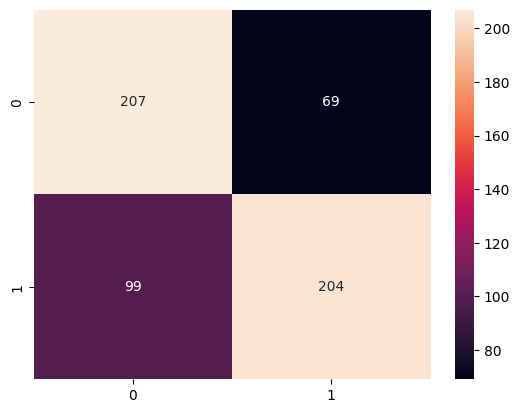

In [46]:
contingency_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [47]:
print(f'NB accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# print(f'NB precision: {metrics.precision_score(y_test, y_pred)}')
# print(f'NB recall: {metrics.recall_score(y_test, y_pred)}')
print(f'NB f1: {f1_score(y_test, y_pred)}')

NB accuracy: 0.7098445595854922
NB f1: 0.7083333333333334


## 4. Random Forest

C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP pavilion X360\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\HP pavilion X360\AppData\Local\Programs\Py

Best params: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 5}


<Axes: >

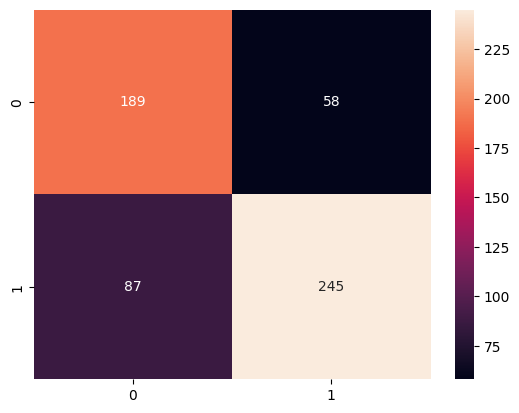

In [48]:
rfc = RandomForestClassifier(random_state = 42, n_jobs = -2)
parameters = {'max_depth':np.arange(1, 30, 2),
             'criterion':['gini', 'entropy'], 'min_samples_split': np.arange(1, 30, 2),
             'class_weight':['balanced', 'balanced_subsample']}
grid = GridSearchCV(rfc, parameters, cv = 4)

grid.fit(ohe_train, y_train)
print(f'Best params: {grid.best_params_}')
rfc_pred = RandomForestClassifier(random_state = 42, max_depth = grid.best_params_['max_depth'],
                                 criterion = grid.best_params_['criterion'],
                                 min_samples_split = grid.best_params_['min_samples_split'],
                                 class_weight = grid.best_params_['class_weight'])
rfc_pred.fit(ohe_train, y_train)
y_pred = rfc_pred.predict(ohe_test)

contingency_matrix = metrics.cluster.contingency_matrix(y_pred,
                                                      y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [49]:
print(f'RFT accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# print(f'RFT precision: {metrics.precision_score(y_test, y_pred)}')
# print(f'RFT recall: {metrics.recall_score(y_test, y_pred)}')
print(f'RFT f1: {f1_score(y_test, y_pred)}')

RFT accuracy: 0.7495682210708118
RFT f1: 0.7716535433070866


## 6. FCALC

In [71]:
method = 'standard'
alpha = 0
bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train.astype(int), y_train.astype(int), method = method, alpha = alpha)
bin_cls.predict(ohe_test.astype(int))
f1_score(y_test, bin_cls.predictions, average = None)

array([0.        , 0.6187291 , 0.59099099])

In [72]:
pat_bin_cls = fcalc.classifier.PatternBinaryClassifier(ohe_train.astype(int), y_train.astype(int), method = method, alpha = alpha)
pat_bin_cls.predict(ohe_test.astype(int))
f1_score(y_test, pat_bin_cls.predictions, average = None)

array([0.        , 0.65505226, 0.65968586])

In [97]:
(y_train == 0).sum()

688

In [101]:
pat_bin_cls.support[0].shape

(2, 579, 661)

In [77]:
b_cls = fcalc.classifier.BinarizedClassifier(ohe_train.astype(int), y_train.astype(int), method = method, alpha = alpha)
b_cls.predict(ohe_test.astype(int))
# f1_score(y_test, b_cls.predictions, average = None)

In [105]:
best_params_f1 = dict()
best_params_acc = dict()
kf = KFold(n_splits=4, shuffle = True, random_state=42)
for train, test in kf.split(ohe_train):
    for alpha in np.arange(0, 10, 3):
        for method in ['standard', 'standard-support', 'standard-ratio']:
            print(method)
            if str(alpha) not in list(best_params_f1.keys()):
                best_params_f1[f'method: {method}, alpha: {alpha}']=[]
                best_params_acc[f'method: {method}, alpha: {alpha}']=[]
            bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train[train].astype(int), y_train.astype(int)[train], method = method, alpha = alpha)
            bin_cls.predict(ohe_train[test].astype(int))
            f1 = f1_score(y_train.astype(int)[test], bin_cls.predictions, average = None)
            acc = accuracy_score(y_train.astype(int)[test], bin_cls.predictions)
            best_params_f1[f'method: {method}, alpha: {alpha}'].append(f1)
            best_params_acc[f'method: {method}, alpha: {alpha}'].append(acc)

standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio
standard
standard-support
standard-ratio


NameError: name 'best_params' is not defined

In [106]:
best_params_f1

{'method: standard, alpha: 0': [array([0.        , 0.61538462, 0.54368932])],
 'method: standard-support, alpha: 0': [array([0., 0., 0.])],
 'method: standard-ratio, alpha: 0': [array([0.65469062, 0.        ])],
 'method: standard, alpha: 3': [array([0., 0., 0.])],
 'method: standard-support, alpha: 3': [array([0.        , 0.34666667, 0.47184987])],
 'method: standard-ratio, alpha: 3': [array([0.65469062, 0.        ])],
 'method: standard, alpha: 6': [array([0., 0., 0.])],
 'method: standard-support, alpha: 6': [array([0.        , 0.34666667, 0.47184987])],
 'method: standard-ratio, alpha: 6': [array([0.65469062, 0.        ])],
 'method: standard, alpha: 9': [array([0., 0., 0.])],
 'method: standard-support, alpha: 9': [array([0.        , 0.34666667, 0.47184987])],
 'method: standard-ratio, alpha: 9': [array([0.65469062, 0.        ])]}

In [44]:
bin_cls = fcalc.classifier.BinarizedBinaryClassifier(ohe_train_sel, y_train, method = 'standard', alpha = 0)
y_pred = bin_cls.predict(ohe_test_sel)

In [45]:
bin_cls.predict(ohe_test_sel)
y_pred = bin_cls.predictions

<Axes: >

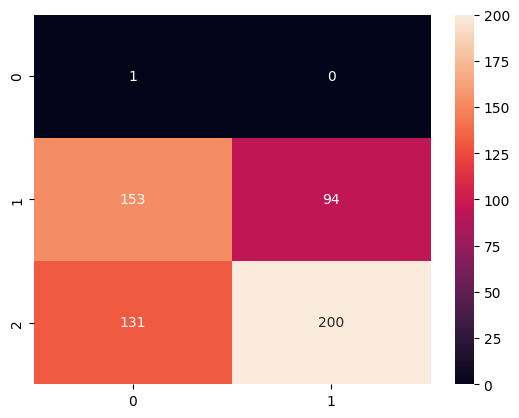

In [46]:
contingency_matrix = metrics.cluster.contingency_matrix(y_pred, y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [52]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'macro'))

0.5941278065630398
0.39669464381782804


## Pattern Structure

In [48]:
best_params = dict()
kf = KFold(n_splits=4, shuffle = True, random_state=42)
# ohe_train_sel = ohe_train.toarray()[:, features].astype(int)
for train, test in kf.split(ohe_train_sel):
    pat_cls = fcalc.classifier.PatternBinaryClassifier(ohe_train_sel[train], y_train[train], categorical=np.arange(ohe_train_sel[test].shape[1]))
    pat_cls.predict(ohe_train_sel[test])
    f1 = f1_score(y_train[test], pat_cls.predictions, average = None)
    # best_params[str(alpha)].append(f1)
    print(f1)

# print(best_params)

[0.59887006 0.55900621]
[0.         0.45756458 0.6318408 ]
[0.         0.61946903 0.60660661]
[0.5915493  0.54545455]


In [49]:
pat_cls = fcalc.classifier.PatternBinaryClassifier(ohe_train_sel, y_train, categorical=np.arange(ohe_train_sel.shape[1]))
pat_cls.predict(ohe_test_sel)

<Axes: >

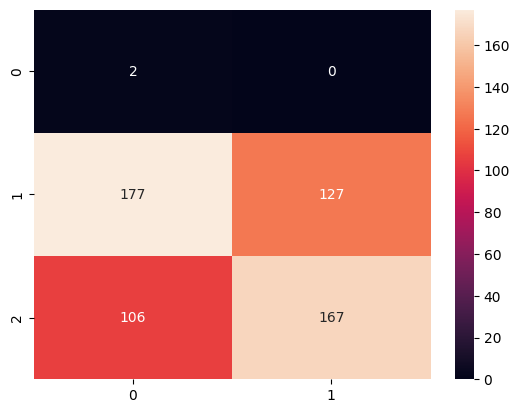

In [50]:
y_pred = pat_cls.predictions
contingency_matrix = metrics.cluster.contingency_matrix(y_pred, y_test)
snx.heatmap(contingency_matrix, annot = True, fmt='')

In [51]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'macro'))

0.5941278065630398
0.39669464381782804


In [107]:
X_con = np.concatenate([ohe_train, ohe_test], axis = 0)
y_con = np.concatenate([y_train, y_test], axis = 0)
X_con.shape, y_con.shape

((1928, 36), (1928,))

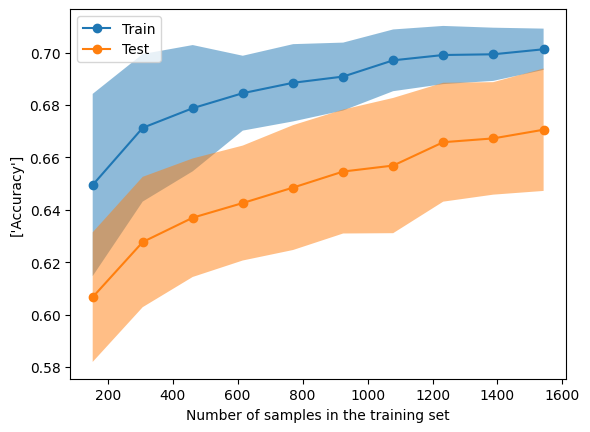

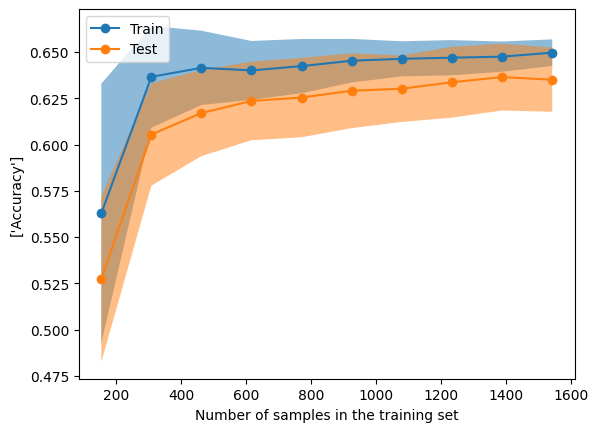

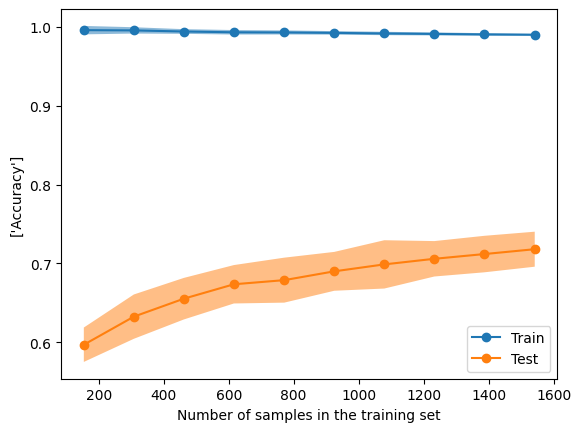

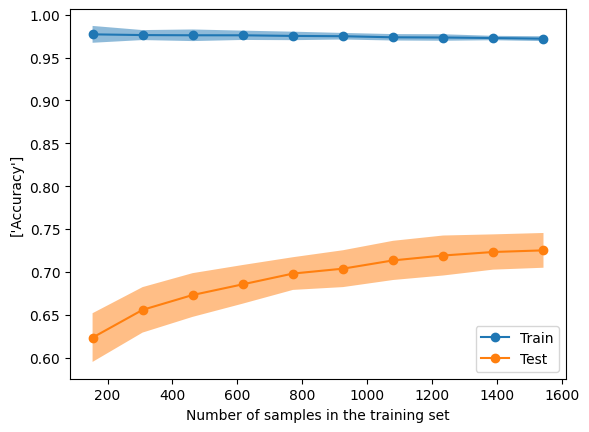

In [108]:
model_quality_acc = dict()
common_params = {
    "X": X_con,
    "y": y_con,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": ["Accuracy"],
}

for estimator in [knn_pred, lr_pred, xgb_reg, rfc_pred]:
    model_quality_acc[estimator.__class__.__name__] = dict()
    learning_curve = LearningCurveDisplay.from_estimator(estimator, **common_params)
    model_quality_acc[estimator.__class__.__name__]['train_scores'] = learning_curve.train_scores.mean(axis = 1)
    model_quality_acc[estimator.__class__.__name__]['test_scores'] = learning_curve.test_scores.mean(axis = 1)
    model_quality_acc[estimator.__class__.__name__]['train_sizes'] = learning_curve.train_sizes

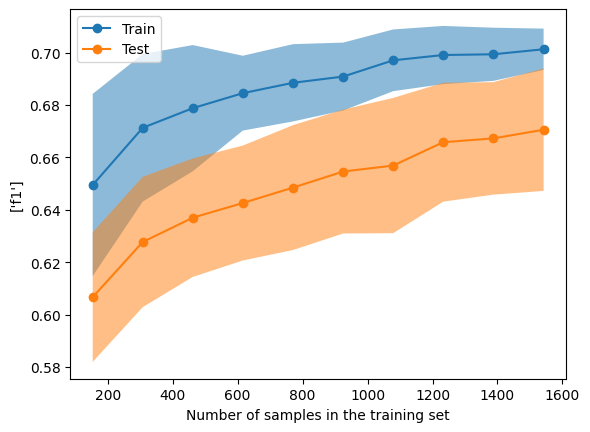

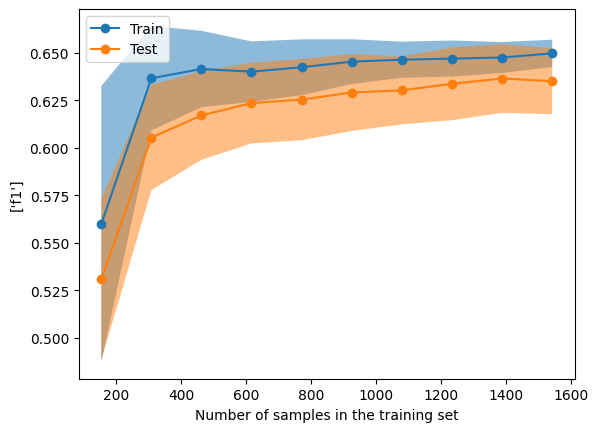

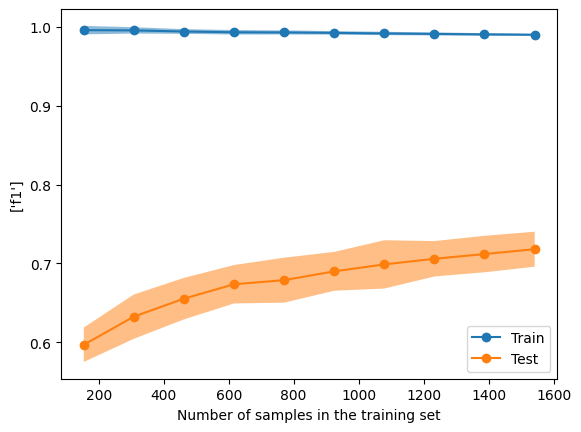

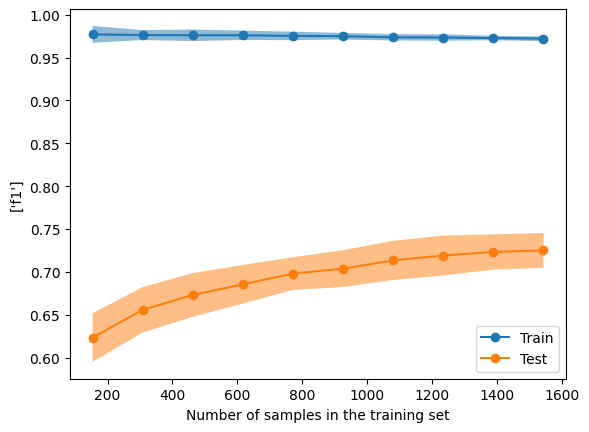

In [110]:
model_quality_f1 = dict()
common_params = {
    "X": X_con,
    "y": y_con,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": ['f1'],
}

for estimator in [knn_pred, lr_pred, xgb_reg, rfc_pred]:
    model_quality_f1[estimator.__class__.__name__] = dict()
    learning_curve = LearningCurveDisplay.from_estimator(estimator, **common_params)
    model_quality_f1[estimator.__class__.__name__]['train_scores'] = learning_curve.train_scores.mean(axis = 1)
    model_quality_f1[estimator.__class__.__name__]['test_scores'] = learning_curve.test_scores.mean(axis = 1)
    model_quality_f1[estimator.__class__.__name__]['train_sizes'] = learning_curve.train_sizes